# Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms

This paper tries to analyze different approximate statistical tests methods to define which one should be used to compare two learning algorithms for a given problem. The original paper can be found on: https://direct.mit.edu/neco/article-abstract/10/7/1895/6224/Approximate-Statistical-Tests-for-Comparing

## Theoretical Introduction

### Type I and Type II Error

We can define the Type I error as the error when we reject the null hypothesis when it is actually true. In this case, we are dealing with a false positive for the alternative.

On the other hand, the Type II error occours when we do not reject the null hypothesis when the alternative is actually true. In this case we have a false negative.

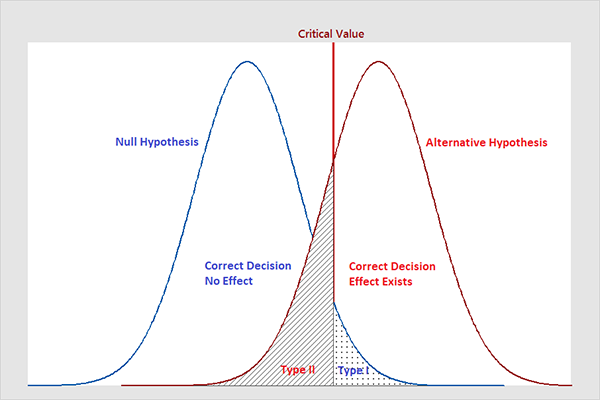

### The Two Proportions Test

The two proportions tests compares the proportion of wrong classified examples (so it is basically 1 - accuracy). It has one assumption that is important:

- It assumes that the samples are independent

As both proportions are calculated on the same test set, they are not, in fact, indepedent. Also, this does not take into account the variance that results may have given the variation of the test set and also does not account for the total dataset, but rather a smaller set used for training.

The null hypothesis is that the difference between the proportions (which is normally distributed since they are both binomial under the assumption that the proportions are independent) has mean zero (hence, the proportions are, on average, the same). The statistics for the test is given by:

$$z = \frac{p_A - p_B}{\sqrt{2p(-1p)/n}}$$

### The Resampled Paired t-test

On this test we set a number of trials (e.g to 30) and measure the proportion of missclassifications for each algorithm on each trial. On this case, we use a holdout on each set. 

Then, we assume that $p^i = p_A^i - p_B^i$ is normally distributed, so we can apply the student's t test with the following statistic:

$$t = \frac{\hat{p}\sqrt{n}}{\sqrt{\frac{\sum_{i=1}^n{(p^i-\hat{p})^2}}{n-1}}}$$

The problems here are:

- The proportions are not independent because they are made on the same test set
- The trials are not independent because there is overlap between the tests sets and the training sets

### The Cross-Validated Paired t-test

This is the same as the test above but we will use the k-fold cross validation technique and not a simple resample. With this test, the test sets do not overlap anymore, however, we still have the training overlap and the dependence betweeen the proportions.

### The McNemar's test

For this test we will train two algorithms on a holdout set and create a contigency table as follows:

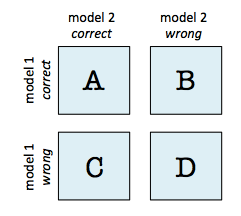!

Under the null hypothesis that the two algorithms should have the same error rate, we can do a $\chi^2$ test on the following statistics:

$$\chi^2 = \frac{(|b - c| - 1)**2}{b+c}$$

The main drawbacks here are:

- We do not take into account train set variation
- We do not take into account internal algorithm variation
- We use a smaller set than the original

However, every test here suffers from the size problem. The advantage of the McNemar's test is that it only requires the algorithms to run once. The paper actually concludes that when the algorithms take too long to run, that this should be used.

### The 2x5 Cross Validation

This method tries to improve on the poor mean estimation of the cross-validated paired t-test. In order to do so, a 2-fold cross validation is repeated 5 times, generating 10 different estimations of proportion difference.

Given that $p^1 = p_A^1 - p_B^1$, $p^2 = p_A^2 - p_B^2$, $\hat{p} = p^1 + p^2 / 2$ and $s^2 = (p^1 - \hat{p})^2 + (p^2 - \hat{p})^2$, the statistic can be calculated as:

$$t^~ = \frac{p_1^1}{\sqrt{\frac{1}{5}\sum^5_1 s_i^2}}$$

This still is not perfect. However, this is the paper suggestion if we can afford to train the models several times.

## Implementation

In [189]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.stats import norm, chi2
from scipy.stats import t as t_dist
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold

# Libs implementations
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
from mlxtend.evaluate import proportion_difference
from mlxtend.evaluate import paired_ttest_kfold_cv
from mlxtend.evaluate import paired_ttest_resampled

### Manual Implementation

In [190]:
def paired_t_test(p):
    p_hat = np.mean(p)
    n = len(p)
    den = np.sqrt(sum([(diff - p_hat)**2 for diff in p]) / (n - 1))
    t = (p_hat * (n**(1/2))) / den
    
    p_value = t_dist.sf(t, n-1)*2
    
    return t, p_value

def mcnemar_test(y_true, y_1, y_2):
    b = sum(np.logical_and((knn_y != y_test),(rf_y == y_test)))
    c = sum(np.logical_and((knn_y == y_test),(rf_y != y_test)))
    
    c_ = (np.abs(b - c) - 1)**2 / (b + c)
    
    p_value = chi2.sf(c_, 1)
    return c_, p_value

def z_test(pa, pb, n):
    p = (pa + pb)/2
    z = (pa - pb) / (((2*p*(1-p))/n)**(1/2))
    
    p_value = norm.cdf(z)
    
    return z, p_value

def five_two_statistic(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p_hat = (p1 + p2) / 2
    s = (p1 - p_hat)**2 + (p2 - p_hat)**2
    t = p1[0] / np.sqrt(1/5. * sum(s))
    
    p_value = t_dist.sf(t, 5)*2
    
    return t, p_value

### Comparison With Existing Methods

In this section I will compare my implementation with the existing implementations from the Mlxtend library to be sure that my functions are correct.

#### Defining the data

In [191]:
X, y = load_wine(return_X_y = True)

#### Defining the Classifiers

In [192]:
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)

#### Data Splitting - Manual Verification

In [193]:
# For holdout cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

rf_y = rf.predict(X_test)
knn_y = knn.predict(X_test)

acc1 = accuracy_score(y_test, rf_y)
acc2 = accuracy_score(y_test, knn_y)

print("Proportions Z-Test")
z, p = proportion_difference(acc1, acc2, n_1=len(y_test))
print(f"z statistic: {z}, p-value: {p}\n")

print("McNemar's test")
chi2_, p = mcnemar_test(y_test, rf_y, knn_y)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

n_tests = 30

p_ = []
rng = np.random.RandomState(42)
for i in range(n_tests):
    randint = rng.randint(low=0, high=32767)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=randint)
    rf.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    acc1 = accuracy_score(y_test, rf.predict(X_test))
    acc2 = accuracy_score(y_test, knn.predict(X_test))
    p_.append(acc1 - acc2)
    
print("Paired t-test Resampled")
t, p = paired_t_test(p_)
print(f"t statistic: {t}, p-value: {p}\n")

p_ = []
# For cross-validated cases
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    acc1 = accuracy_score(y_test, rf.predict(X_test))
    acc2 = accuracy_score(y_test, knn.predict(X_test))
    p_.append(acc1 - acc2)

print("Cross Validated Paired t-test")
t, p = paired_t_test(p_)
print(f"t statistic: {t}, p-value: {p}\n")

p_1 = []
p_2 = []
# For the 5x2cv
rng = np.random.RandomState(42)
for i in range(5):
    randint = rng.randint(low=0, high=32767)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=randint)

    rf.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    acc1 = accuracy_score(y_test, rf.predict(X_test))
    acc2 = accuracy_score(y_test, knn.predict(X_test))
    p_1.append(acc1 - acc2)

    rf.fit(X_test, y_test)
    knn.fit(X_test, y_test)
    acc1 = accuracy_score(y_train, rf.predict(X_train))
    acc2 = accuracy_score(y_train, knn.predict(X_train))
    p_2.append(acc1 - acc2)

print("5x2 CV Paired t-test")     
t, p = five_two_statistic(p_1, p_2)
print(f"t statistic: {t}, p-value: {p}\n")

Proportions Z-Test
z statistic: 3.2071349029490928, p-value: 0.9993296794413853

McNemar's test
chi² statistic: 6.125, p-value: 0.01332832878081758

Paired t-test Resampled
t statistic: 20.825868869252297, p-value: 5.467889135932688e-19

Cross Validated Paired t-test
t statistic: 9.468833293996424, p-value: 5.6252171240942e-06

5x2 CV Paired t-test
t statistic: 6.454972243679027, p-value: 0.0013279254349912806



#### Mlxtend

In [194]:
print("Proportions Z-Test")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

rf_y = rf.predict(X_test)
knn_y = knn.predict(X_test)

acc1 = accuracy_score(y_test, rf_y)
acc2 = accuracy_score(y_test, knn_y)

z, p = proportion_difference(acc1, acc2, n_1=len(y_test))
print(f"z statistic: {z}, p-value: {p}\n")

print("McNemar's test")
table = mcnemar_table(y_target=y_test, y_model1=rf_y, y_model2=knn_y)
chi2_, p = mcnemar(ary=table, corrected=True)
print(f"chi² statistic: {chi2_}, p-value: {p}\n")

print("Paired t-test Resampled")
t, p = paired_ttest_resampled(estimator1=rf, estimator2=knn, X=X, y=y, random_seed=42, num_rounds=30, test_size=0.2)
print(f"t statistic: {t}, p-value: {p}\n")

print("Cross Validated Paired t-test")
t, p = paired_ttest_kfold_cv(estimator1=rf, estimator2=knn, X=X, y=y, random_seed=42, shuffle=True, cv=10)
print(f"t statistic: {t}, p-value: {p}\n")

print("5x2 CV Paired t-test")
t, p = paired_ttest_5x2cv(estimator1=rf, estimator2=knn, X=X, y=y, random_seed=42)
print(f"t statistic: {t}, p-value: {p}\n")

Proportions Z-Test
z statistic: 3.2071349029490928, p-value: 0.9993296794413853

McNemar's test
chi² statistic: 6.125, p-value: 0.01332832878081758

Paired t-test Resampled
t statistic: 20.825868869252297, p-value: 5.467889135932688e-19

Cross Validated Paired t-test
t statistic: 9.468833293996424, p-value: 5.6252171240942e-06

5x2 CV Paired t-test
t statistic: 6.454972243679027, p-value: 0.0013279254349912806

